In [15]:
import matplotlib.pyplot as plt
import numpy as np
import abtem
from ase import Atoms
import ase
from abtem.core.energy import energy2wavelength
from scipy.interpolate import RegularGridInterpolator
%matplotlib ipympl

In [16]:
def get_phase_from_opl(opl, wavelength):
    return np.mod((opl/wavelength) * (2*np.pi), 2*np.pi)

def convert_slope_to_unit_vector(dx, dy):
    
    rho = np.sqrt(1 + dx ** 2 + dy ** 2)
    unit_vector_x = dx / rho
    unit_vector_y = dy / rho
    unit_vector_z = 1 / rho

    return np.array([unit_vector_x, unit_vector_y, unit_vector_z])

In [27]:
# Define the number of slices and slice thickness
slice_thickness = 0.2  # in Angstroms

# Calculate the total thickness of the cell
total_thickness = 1

num_slices = int(total_thickness / slice_thickness)

cell_x = 2
cell_y = 2
cell_z = total_thickness

# # # Create a cell with a large z-dimension
# cell = [cell_x, cell_y, cell_z]  # 10x10 Angstroms in x and y, total_thickness in z

# # # Place a single gold atom at the center of the cell
# position = [cell_x / 2, cell_y / 2, total_thickness / 2]
# atoms = Atoms('Au', positions=[position], cell=cell, pbc=[False, False, False])

unit_cell = ase.build.bulk("Au", cubic=True)
atoms = unit_cell * (cell_x, cell_y, cell_z)

# Get the size of the unit cell in Angstroms
unit_cell_size = unit_cell.cell.lengths()

# Calculate the size of the supercell
supercell_size_x = unit_cell_size[0] * cell_x
supercell_size_y = unit_cell_size[1] * cell_y
supercell_size_z = unit_cell_size[2] * cell_z

# Calculate the extent of the cell
half_x = supercell_size_x / 2
half_y = supercell_size_y / 2
half_z = supercell_size_z / 2

extent_x = (-half_x / 2, half_x / 2)
extent_y = (-half_y / 2, half_y / 2)
extent_z = (-half_z / 2, half_z / 2)

potential = abtem.Potential(
    atoms,
    slice_thickness=slice_thickness,
    sampling=0.05,
    projection="finite",
)

PHI_0 = 80e3
wavelength = energy2wavelength(PHI_0)

# Compute the potential
V = potential.build().compute().array

# Define the offset (atom position)
offset = [0, 0, 0]  # Place the atom at the origin

print(half_x, half_y)
# half_x = cell[0] / 2
# half_y = cell[1] / 2
# half_z = cell[2] / 2

[########################################] | 100% Completed | 403.82 ms
4.08 4.08


Text(0.5, 1.0, 'Potential')

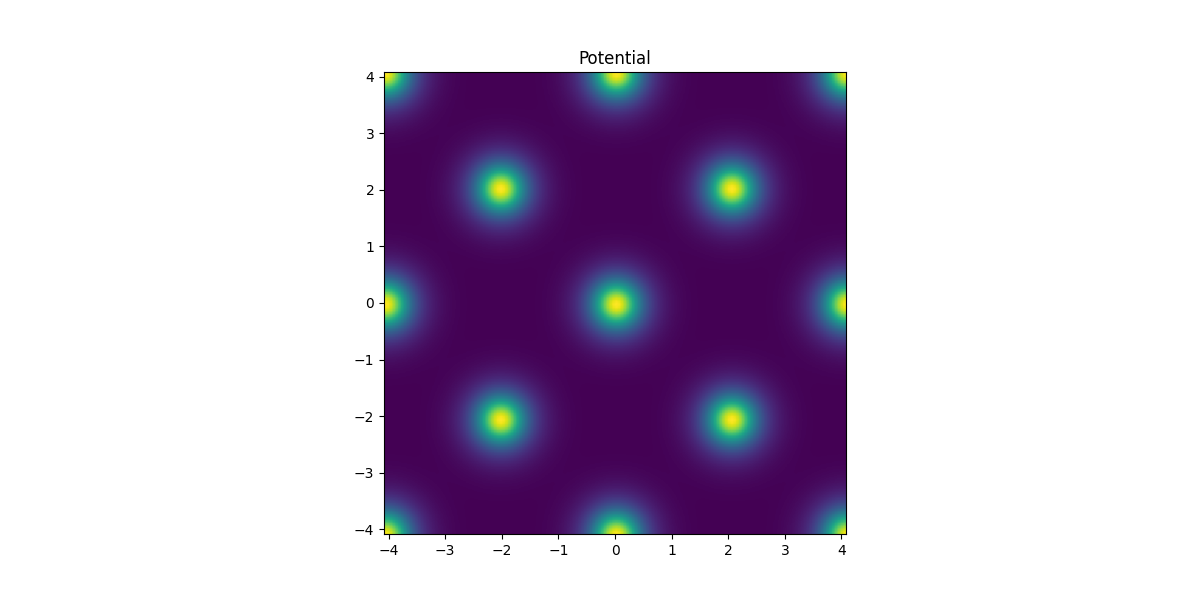

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(V[2, :, :], extent = (-half_x, half_x, -half_y, half_y))
ax.set_title('Potential')


In [19]:
k = 2 * np.pi / wavelength

V_xyz = PHI_0 - V.T

n = np.sqrt(V_xyz / PHI_0)
dndx, dndy, dndz = np.gradient(n)

nx, ny, nz = V.T.shape

x = np.linspace(-half_x, half_x, nx, endpoint = False)  # x coordinates
y = np.linspace(-half_y, half_y, ny, endpoint = False)  # y coordinates
z = np.linspace(-half_z, half_z, nz, endpoint = True)  # z coordinates

n_interp = RegularGridInterpolator((x, y, z), n, method = 'linear', bounds_error=False, fill_value=1.0)
dndx_interp = RegularGridInterpolator((x, y, z), dndx, method = 'linear', bounds_error=False, fill_value=0.0)
dndy_interp = RegularGridInterpolator((x, y, z), dndy, method = 'linear', bounds_error=False, fill_value=0.0)
dndz_interp = RegularGridInterpolator((x, y, z), dndz, method = 'linear', bounds_error=False, fill_value=0.0)

xx, yy = np.meshgrid(x, y)

In [20]:
def step_slice(r, z, dz, n, dndx, dndy, dndz):

    #Use the Euler-Cromer method to step the electron through the refractive index potential
    
    #Get coordinates
    x, dx, y, dy, opl = r.T
    
    #Get tangent vector from slope
    rho = np.sqrt(1 + dx **2 + dy ** 2)
    
    #Update slopes
    dx = dx + rho ** 2 / n((x, y, z)) * (dndx((x, y, z)) - dx * dndz((x, y, z))) * dz
    dy = dy + rho ** 2 / n((x, y, z)) * (dndy((x, y, z)) - dy * dndz((x, y, z))) * dz
    
    #Update positions
    x = x + dx * dz
    y = y + dy * dz
    z = z + dz
    
    #Add phase shift
    opl = opl + n((x, y, z)) * rho * dz
    
    #Return updated coordinates to vector
    r = np.vstack((x, dx, y, dy, opl)).T
    
    return r, z

def step_z(r, z, dz):
    x, dx, y, dy, opl = r.T
    rho = np.sqrt(1 + dx **2 + dy ** 2)
    
    x = x + dx * dz
    y = y + dy * dz
    z = z + dz
    opl += 1.0 * rho * dz
    
    r = np.vstack((x, dx, y, dy, opl)).T
    
    return r, z

In [28]:
num_rays = 1000
z0_atom = -half_z
dz = slice_thickness

# Generate random angles and radii
angles = np.random.uniform(0, 2 * np.pi, num_rays)
radii = np.random.uniform(0, half_x, num_rays)

# Convert polar coordinates to Cartesian coordinates
x0s = radii * np.cos(angles)
y0s = radii * np.sin(angles)


z0 = -1000

dx0 = 0.0
dy0 = 0.0
opl0 = 0.0

rho = np.sqrt(dx0 ** 2 + dy0 ** 2)
dz0 = z0_atom - z0
z1 = z0 + dz0

r = np.zeros((num_rays, num_slices + 3, 5))

z_sol = np.zeros(num_slices + 3)
z_sol[0] = z0

r[:, 0, 0] = x0s
r[:, 0, 1] = dx0
r[:, 0, 2] = y0s
r[:, 0, 3] = dy0
r[:, 0, 4] = opl0


In [29]:

r[:, 1, :], z_sol[1] = step_z(r[:, 0, :], z_sol[0], dz0)
i_start = 1

for i in range(num_slices):
    r[:, i + i_start + 1, :], z_sol[i + i_start + 1] = step_slice(r[:, i + i_start, :], z_sol[i + i_start], dz, n_interp, dndx_interp, dndy_interp, dndz_interp)

dzend = 1000000
r[:, -1, :], z_sol[-1] = step_z(r[:, -2, :], z_sol[-2], dzend)

x_sol = r[:, :, 0]

In [30]:
# fig, ax = plt.subplots()
# ax.plot(z_sol, x_sol.T, '-')
# ax.set_xlabel("z (angstroms)")
# ax.set_ylabel("x (angstroms)")
# ax.set_title("Particle Trajectory around atomic potential")

In [31]:
n_pixels_x = 200
n_pixels_y = 200
detector_width_x = 5000
detector_width_y = 5000

# Create 2D grid for detector pixels
detector_pixels_x = np.linspace(-detector_width_x/2, detector_width_x/2, n_pixels_x)
detector_pixels_y = np.linspace(-detector_width_y/2, detector_width_y/2, n_pixels_y)
detector_pixels_z = np.ones((n_pixels_x, n_pixels_y)) * z_sol[-1]

# Create a meshgrid for detector points
detector_pixels_x, detector_pixels_y = np.meshgrid(detector_pixels_x, detector_pixels_y)

det_points = np.vstack([
    detector_pixels_x.ravel(), 
    detector_pixels_y.ravel(), 
    detector_pixels_z.ravel()
]).T

print(det_points.shape)

(40000, 3)


In [32]:
det_pixels = np.zeros((n_pixels_x, n_pixels_y), np.complex128)

x, dx, y, dy, opl = r[:, -1, :].T

ray_unit_direction_vector = convert_slope_to_unit_vector(dx, dy).T #z, x
ray_points = np.vstack([x, y, np.ones(num_rays) * z_sol[-1]]).T #z, x

ray_phase = get_phase_from_opl(opl, 2)

for i in range(num_rays):
    v = ray_points[i, :] - det_points
    dist = np.dot(v, ray_unit_direction_vector[i, :].T)
    phase_shift_to_detector = get_phase_from_opl(dist, wavelength)
    
    phase_shift_to_detector = phase_shift_to_detector.reshape(n_pixels_x, n_pixels_y)
    det_pixels += 1.0 * np.exp(1j * (ray_phase[i] + phase_shift_to_detector))


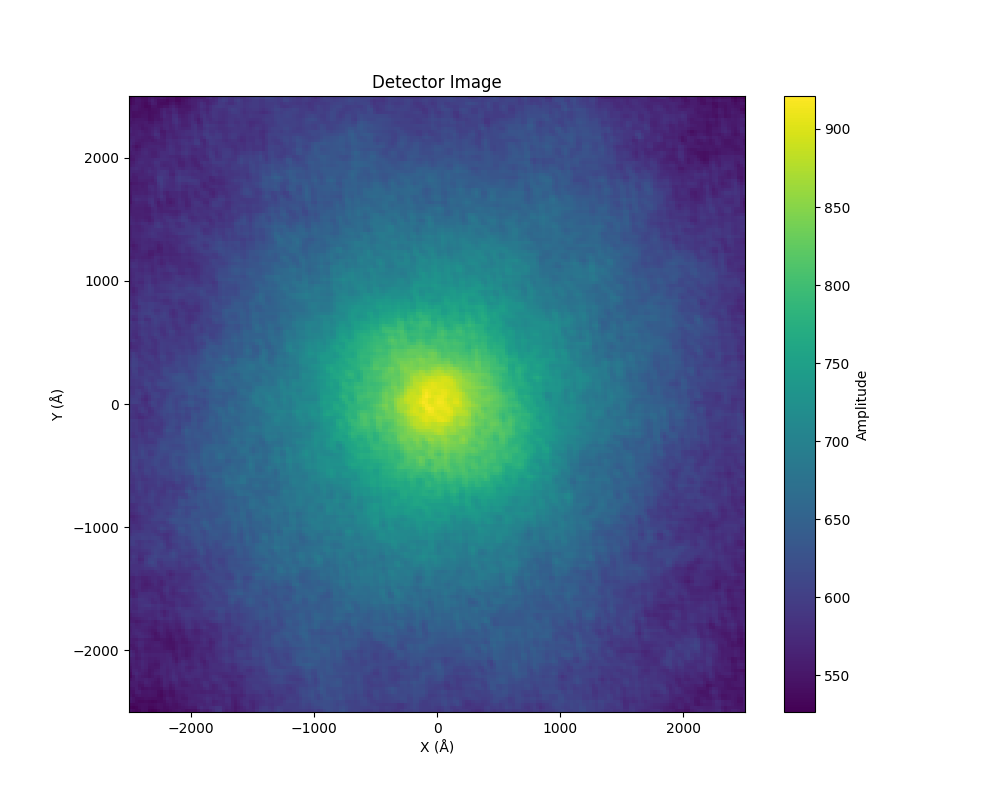

In [33]:
# Plotting the detector pixels
plt.figure(figsize=(10, 8))
plt.imshow(np.abs(det_pixels), extent=[-detector_width_x/2, detector_width_x/2, -detector_width_y/2, detector_width_y/2], cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')
plt.title('Detector Image')
plt.show()